**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead).

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=100, tol=-np.infty, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


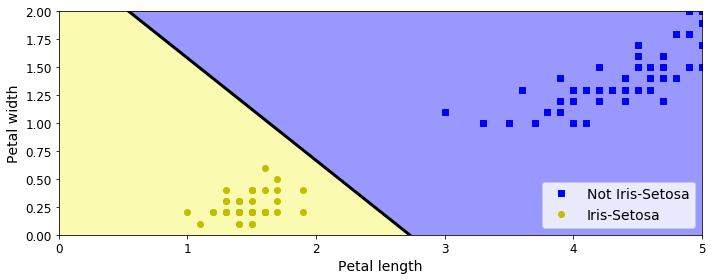

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


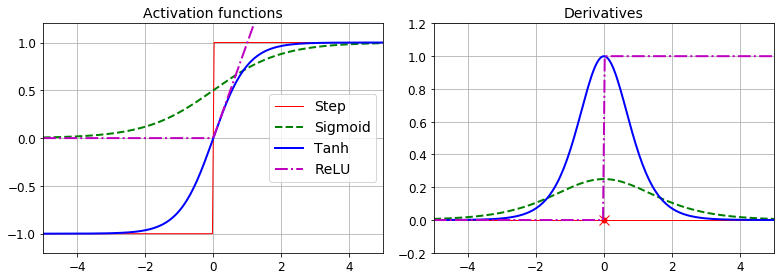

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

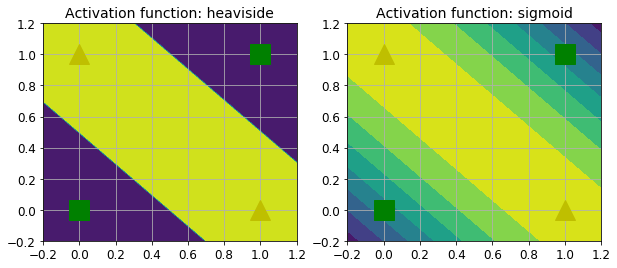

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
tf.__version__

'1.13.0-dev20190116'

In [11]:
keras.__version__

'2.2.4-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [13]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [14]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

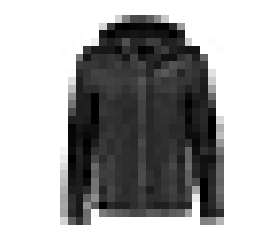

In [16]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [19]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist


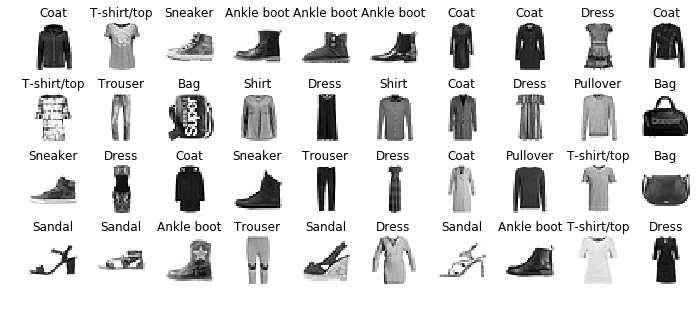

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist', tight_layout=False)
plt.show()

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.layers

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


**Warning**: the following 2 cells do not work yet due to [TensorFlow issue 24622](https://github.com/tensorflow/tensorflow/issues/24622) (you are using a preview version of TensorFlow, hence there are still a few issues).
You can work around this issue by applying [PR 24626](https://github.com/tensorflow/tensorflow/pull/24625/files) to your copy of `tensorflow/python/keras/utils/vis_utils.py`.

In [28]:
#keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [29]:
%%html
<img src="my_mnist_model.png" />

**Warning**: the following cell does not work yet due to [TensorFlow issue 24622](https://github.com/tensorflow/tensorflow/issues/24622) and [TensorFlow issue 24639](https://github.com/tensorflow/tensorflow/issues/24639).
You can work around issue 24639 by writing `from tensorflow.keras.utils.vis_utils import model_to_dot`.

In [30]:
from IPython.display import SVG
#SVG(keras.utils.model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [31]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

In [32]:
model.get_layer(hidden1.name).name

'dense_3'

In [33]:
weights, biases = hidden1.get_weights()

In [34]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [35]:
weights.shape

(784, 300)

In [36]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
biases.shape

(300,)

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [39]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.Accuracy()])

In [40]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000==============================] - 3s 55us/sample - loss: 1.4948 - accuracy: 0.0000e+00 - val_loss: 1.0042 - val_accuracy: 0.0000e+00
Epoch 2/50
55000/55000==============================] - 3s 57us/sample - loss: 0.8690 - accuracy: 0.0000e+00 - val_loss: 0.7549 - val_accuracy: 0.0000e+00
Epoch 3/50
55000/55000==============================] - 3s 54us/sample - loss: 0.7176 - accuracy: 0.0000e+00 - val_loss: 0.6611 - val_accuracy: 0.0000e+00
Epoch 4/50
55000/55000==============================] - 3s 54us/sample - loss: 0.6459 - accuracy: 0.0000e+00 - val_loss: 0.6049 - val_accuracy: 0.0000e+00
Epoch 5/50
55000/55000==============================] - 3s 57us/sample - loss: 0.5995 - accuracy: 0.0000e+00 - val_loss: 0.5691 - val_accuracy: 0.0000e+00
Epoch 6/50
55000/55000==============================] - 3s 50us/sample - loss: 0.5673 - accuracy: 0.0000e+00 - val_loss: 0.5432 - val_accuracy: 0.0000e+00
Epoch 7/50
55000/5500

In [41]:
history.params

{'batch_size': 32,
 'epochs': 50,
 'steps': None,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [42]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curve_graph


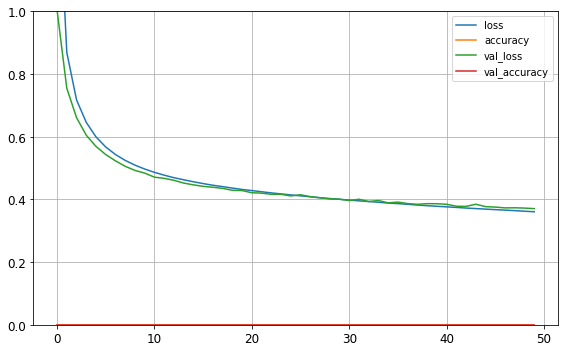

In [44]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curve_graph")
plt.show()

In [45]:
model.evaluate(X_test, y_test)

10000/10000==============================] - 0s 29us/sample - loss: 0.4074 - accuracy: 0.0000e+00


[0.4073760202884674, 0.0]

In [46]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.12, 0.  , 0.79],
       [0.  , 0.  , 0.94, 0.  , 0.02, 0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [47]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [49]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [50]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610==============================] - 1s 44us/sample - loss: 1.6343 - val_loss: 0.9361
Epoch 2/20
11610/11610==============================] - 0s 32us/sample - loss: 0.7053 - val_loss: 0.6556
Epoch 3/20
11610/11610==============================] - 0s 33us/sample - loss: 0.6343 - val_loss: 0.6028
Epoch 4/20
11610/11610==============================] - 0s 33us/sample - loss: 0.5974 - val_loss: 0.5631
Epoch 5/20
11610/11610==============================] - 0s 32us/sample - loss: 0.5701 - val_loss: 0.5375
Epoch 6/20
11610/11610==============================] - 0s 35us/sample - loss: 0.5474 - val_loss: 0.5165
Epoch 7/20
11610/11610==============================] - 0s 37us/sample - loss: 0.5283 - val_loss: 0.5072
Epoch 8/20
11610/11610==============================] - 0s 33us/sample - loss: 0.5130 - val_loss: 0.4806
Epoch 9/20
11610/11610==============================] - 0s 32us/sample - loss: 0.4989 - val_loss: 0.4712
Epoch 

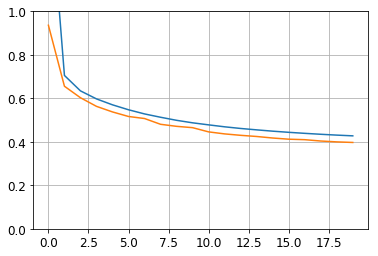

In [53]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [54]:
y_pred

array([[0.38745382],
       [1.6820507 ],
       [3.0960472 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input], outputs=[output])

In [57]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           930         dense_8[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_9[0][0]                    
__________

In [58]:
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610==============================] - 1s 50us/sample - loss: 1.2544 - val_loss: 2.9415
Epoch 2/20
11610/11610==============================] - 0s 32us/sample - loss: 0.6531 - val_loss: 0.8754
Epoch 3/20
11610/11610==============================] - 0s 32us/sample - loss: 0.5873 - val_loss: 0.5529
Epoch 4/20
11610/11610==============================] - 0s 35us/sample - loss: 0.5574 - val_loss: 0.5205
Epoch 5/20
11610/11610==============================] - 0s 36us/sample - loss: 0.5343 - val_loss: 0.5399
Epoch 6/20
11610/11610==============================] - 0s 34us/sample - loss: 0.5160 - val_loss: 0.4793
Epoch 7/20
11610/11610==============================] - 0s 32us/sample - loss: 0.5004 - val_loss: 0.4655
Epoch 8/20
11610/11610==============================] - 0s 33us/sample - loss: 0.4873 - val_loss: 0.4820
Epoch 9/20
11610/11610==============================] - 0s 32us/sample - loss: 0.4761 - val_loss: 0.4421
Epoch 

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [61]:
model.compile(loss="mse", optimizer="sgd")

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610==============================] - 1s 53us/sample - loss: 1.8070 - val_loss: 0.8422
Epoch 2/20
11610/11610==============================] - 0s 35us/sample - loss: 0.6752 - val_loss: 0.6426
Epoch 3/20
11610/11610==============================] - 0s 35us/sample - loss: 0.5969 - val_loss: 0.5829
Epoch 4/20
11610/11610==============================] - 0s 35us/sample - loss: 0.5580 - val_loss: 0.5259
Epoch 5/20
11610/11610==============================] - 0s 35us/sample - loss: 0.5317 - val_loss: 0.5005
Epoch 6/20
11610/11610==============================] - 0s 34us/sample - loss: 0.5125 - val_loss: 0.4792
Epoch 7/20
11610/11610==============================] - 0s 35us/sample - loss: 0.4963 - val_loss: 0.4786
Epoch 8/20
11610/11610==============================] - 0s 35us/sample - loss: 0.4840 - val_loss: 0.4562
Epoch 9/20
11610/11610==============================] - 0s 34us/sample - loss: 0.4733 - val_loss: 0.4407
Epoch 

Adding an auxiliary output for regularization:

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [64]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

In [65]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610==============================] - 1s 83us/sample - loss: 2.1325 - dense_16_loss: 1.9139 - dense_17_loss: 4.0950 - val_loss: 1.6650 - val_dense_16_loss: 0.8892 - val_dense_17_loss: 8.6440
Epoch 2/20
11610/11610==============================] - 1s 47us/sample - loss: 0.8870 - dense_16_loss: 0.6930 - dense_17_loss: 2.6303 - val_loss: 1.4991 - val_dense_16_loss: 0.6627 - val_dense_17_loss: 9.0235
Epoch 3/20
11610/11610==============================] - 1s 49us/sample - loss: 0.7421 - dense_16_loss: 0.6079 - dense_17_loss: 1.9515 - val_loss: 1.4340 - val_dense_16_loss: 0.5748 - val_dense_17_loss: 9.1628
Epoch 4/20
11610/11610==============================] - 1s 44us/sample - loss: 0.6766 - dense_16_loss: 0.5683 - dense_17_loss: 1.6515 - val_loss: 1.3260 - val_dense_16_loss: 0.5579 - val_dense_17_loss: 8.2343
Epoch 5/20
11610/11610==============================] - 1s 45us/sample - loss: 0.6366 - dense_16_loss: 0.5422 - den

In [66]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160==============================] - 0s 22us/sample - loss: 0.4661 - dense_16_loss: 0.4167 - dense_17_loss: 0.9138


# The subclassing API

In [67]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu"):
        super().__init__()
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [68]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer="sgd")
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610==============================] - 1s 81us/sample - loss: 2.2914 - output_1_loss: 2.1790 - output_2_loss: 3.2954 - val_loss: 2.7823 - val_output_1_loss: 2.0246 - val_output_2_loss: 9.5935
Epoch 2/10
11610/11610==============================] - 1s 44us/sample - loss: 0.9834 - output_1_loss: 0.8678 - output_2_loss: 2.0207 - val_loss: 1.6646 - val_output_1_loss: 0.7720 - val_output_2_loss: 9.6934
Epoch 3/10
11610/11610==============================] - 1s 44us/sample - loss: 0.8264 - output_1_loss: 0.7295 - output_2_loss: 1.6967 - val_loss: 1.4471 - val_output_1_loss: 0.6947 - val_output_2_loss: 8.2170
Epoch 4/10
11610/11610==============================] - 1s 44us/sample - loss: 0.7616 - output_1_loss: 0.6750 - output_2_loss: 1.5418 - val_loss: 1.2658 - val_output_1_loss: 0.6379 - val_output_2_loss: 6.9130
Epoch 5/10
11610/11610==============================] - 1s 43us/sample - loss: 0.7203 - output_1_loss: 0.6400 - out

In [69]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [72]:
model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610==============================] - 1s 64us/sample - loss: 1.8807 - val_loss: 0.7701
Epoch 2/10
11610/11610==============================] - 0s 34us/sample - loss: 0.6570 - val_loss: 0.7268
Epoch 3/10
11610/11610==============================] - 0s 34us/sample - loss: 0.5932 - val_loss: 0.6569
Epoch 4/10
11610/11610==============================] - 0s 34us/sample - loss: 0.5547 - val_loss: 0.5244
Epoch 5/10
11610/11610==============================] - 0s 33us/sample - loss: 0.5269 - val_loss: 0.5068
Epoch 6/10
11610/11610==============================] - 0s 36us/sample - loss: 0.5035 - val_loss: 0.5028
Epoch 7/10
11610/11610==============================] - 0s 35us/sample - loss: 0.4852 - val_loss: 0.4924
Epoch 8/10
11610/11610==============================] - 0s 37us/sample - loss: 0.4709 - val_loss: 0.4534
Epoch 9/10
11610/11610==============================] - 0s 33us/sample - loss: 0.4578 - val_loss: 0.4403
Epoch 

In [73]:
model.save("my_keras_model.h5")

In [74]:
model = keras.models.load_model("my_keras_model.h5")

In [75]:
model.predict(X_new)

array([[0.54925185],
       [1.6747888 ],
       [3.0483947 ]], dtype=float32)

In [76]:
model.save_weights("my_keras_weights.ckpt")

In [77]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [80]:
model.compile(loss="mse", optimizer="sgd")
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610==============================] - 1s 71us/sample - loss: 1.8807 - val_loss: 0.7701
Epoch 2/10
11610/11610==============================] - 0s 35us/sample - loss: 0.6570 - val_loss: 0.7268
Epoch 3/10
11610/11610==============================] - 0s 36us/sample - loss: 0.5932 - val_loss: 0.6569
Epoch 4/10
11610/11610==============================] - 0s 35us/sample - loss: 0.5547 - val_loss: 0.5244
Epoch 5/10
11610/11610==============================] - 0s 35us/sample - loss: 0.5269 - val_loss: 0.5068
Epoch 6/10
11610/11610==============================] - 0s 35us/sample - loss: 0.5035 - val_loss: 0.5028
Epoch 7/10
11610/11610==============================] - 0s 35us/sample - loss: 0.4852 - val_loss: 0.4924
Epoch 8/10
11610/11610==============================] - 0s 35us/sample - loss: 0.4709 - val_loss: 0.4534
Epoch 9/10
11610/11610==============================] - 0s 35us/sample - loss: 0.4578 - val_loss: 0.4403
Epoch 

In [81]:
model.compile(loss="mse", optimizer="sgd")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 72us/sample - loss: 0.4483 - val_loss: 0.4280
Epoch 2/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4393 - val_loss: 0.4106
Epoch 3/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4319 - val_loss: 0.4078
Epoch 4/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4262 - val_loss: 0.4037
Epoch 5/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4205 - val_loss: 0.3956
Epoch 6/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4160 - val_loss: 0.3894
Epoch 7/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4116 - val_loss: 0.3891
Epoch 8/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4077 - val_loss: 0.3817
Epoch 9/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4041 - val_loss: 0.37

In [82]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [83]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
11168/11610===========================>..] - ETA: 0s - loss: 0.3464
val/train: 0.98
11610/11610==============================] - 0s 35us/sample - loss: 0.3467 - val_loss: 0.3384


# TensorBoard

In [84]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [85]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2019_01_16-23_13_22'

In [86]:
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
#model.compile(loss="mse", optimizer="sgd")
# or try another learning rate:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [88]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610==============================] - 1s 79us/sample - loss: 0.5259 - val_loss: 0.4834
Epoch 2/30
11610/11610==============================] - 0s 34us/sample - loss: 0.4069 - val_loss: 0.3912
Epoch 3/30
11610/11610==============================] - 0s 36us/sample - loss: 0.3744 - val_loss: 7.5516
Epoch 4/30
11610/11610==============================] - 0s 38us/sample - loss: 0.3656 - val_loss: 1.1554
Epoch 5/30
11610/11610==============================] - 0s 38us/sample - loss: 0.3526 - val_loss: 0.4557
Epoch 6/30
11610/11610==============================] - 0s 37us/sample - loss: 0.3459 - val_loss: 0.3200
Epoch 7/30
11610/11610==============================] - 0s 36us/sample - loss: 0.3354 - val_loss: 0.3228
Epoch 8/30
11610/11610==============================] - 0s 38us/sample - loss: 0.3328 - val_loss: 0.3086
Epoch 9/30
11610/11610==============================] - 0s 37us/sample - loss: 0.3219 - val_loss: 0.3210
Epoch 

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can create a Jupyter cell with this code:

```bash
%%bash
tensorboard --logdir={run_logdir} --port=6006
```

When you run this cell, the TensorBoard server will start and you can use it at [localhost:6006](http://localhost:6006), but Jupyter will be blocked until you interrupt this cell, which will shutdown the server.

Lastly, you can use the following `tb()` function that starts the TensorBoard server in a way that does not block Jupyter, and directly opens a new browser tab for you. It returns a handle on the server's process, so you can call `server.kill()` when you want to shutdown the server. Note that interrupting this notebook will shutdown all TensorBoard servers that you started this way.

You may also want to install the jupyter-tensorboard extension which integrates nicely into Jupyter to start/stop TensorBoard servers.

In [89]:
def tb(logdir=root_logdir, port=6006, open_tab=True, sleep=3):
    import subprocess
    proc = subprocess.Popen(
        "tensorboard --logdir={0} --port={1}".format(logdir, port), shell=True)
    if open_tab:
        import time
        print("Waiting a few seconds for the TensorBoard Server to start...")
        time.sleep(sleep)
        import webbrowser
        webbrowser.open("http://127.0.0.1:{}/".format(port))
    return proc

In [90]:
server = tb()

Waiting a few seconds for the TensorBoard Server to start...


In [91]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2019_01_16-23_13_38'

In [92]:
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.015))

In [95]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610==============================] - 1s 80us/sample - loss: 0.5997 - val_loss: 0.4971
Epoch 2/10
11610/11610==============================] - 0s 41us/sample - loss: 0.4173 - val_loss: 1.5356
Epoch 3/10
11610/11610==============================] - 0s 41us/sample - loss: 0.3927 - val_loss: 28.6786
Epoch 4/10
11610/11610==============================] - 0s 39us/sample - loss: 0.4054 - val_loss: 7.2650
Epoch 5/10
11610/11610==============================] - 0s 40us/sample - loss: 0.4046 - val_loss: 0.6207
Epoch 6/10
11610/11610==============================] - 0s 40us/sample - loss: 0.3645 - val_loss: 0.3646
Epoch 7/10
11610/11610==============================] - 0s 39us/sample - loss: 0.3516 - val_loss: 0.3539
Epoch 8/10
11610/11610==============================] - 0s 38us/sample - loss: 0.3480 - val_loss: 0.3315
Epoch 9/10
11610/11610==============================] - 0s 39us/sample - loss: 0.3464 - val_loss: 0.3483
Epoch

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

In [96]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    Initialize self.  See help(type(self)) for accurate signature.



In [97]:
#server.kill() # uncomment and run this to stop the TensorBoard server

# Hyperparameter Tuning

In [98]:
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [100]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [101]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 79us/sample - loss: 1.0910 - val_loss: 21.1892
Epoch 2/100
11610/11610==============================] - 0s 38us/sample - loss: 0.7607 - val_loss: 4.8909
Epoch 3/100
11610/11610==============================] - 0s 36us/sample - loss: 0.5401 - val_loss: 0.5721
Epoch 4/100
11610/11610==============================] - 0s 42us/sample - loss: 0.4752 - val_loss: 0.4433
Epoch 5/100
11610/11610==============================] - 0s 35us/sample - loss: 0.4499 - val_loss: 0.4270
Epoch 6/100
11610/11610==============================] - 0s 37us/sample - loss: 0.4348 - val_loss: 0.4165
Epoch 7/100
11610/11610==============================] - 0s 41us/sample - loss: 0.4240 - val_loss: 0.4060
Epoch 8/100
11610/11610==============================] - 0s 36us/sample - loss: 0.4166 - val_loss: 0.4030
Epoch 9/100
11610/11610==============================] - 0s 36us/sample - loss: 0.4109 - val_loss: 0.4

In [102]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160==============================] - 0s 16us/sample - loss: 0.3504


In [103]:
y_pred = keras_reg.predict(X_new)

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

In [105]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
7740/7740==============================] - 1s 104us/sample - loss: 3.5539 - val_loss: 1.8522
Epoch 2/100
7740/7740==============================] - 0s 36us/sample - loss: 1.3322 - val_loss: 1.0094
Epoch 3/100
7740/7740==============================] - 0s 36us/sample - loss: 0.8593 - val_loss: 0.7356
Epoch 4/100
7740/7740==============================] - 0s 39us/sample - loss: 0.7338 - val_loss: 0.6880
Epoch 5/100
7740/7740==============================] - 0s 35us/sample - loss: 0.6915 - val_loss: 0.8475
Epoch 6/100
7740/7740==============================] - 0s 37us/sample - loss: 0.6710 - val_loss: 0.6480
Epoch 7/100
7740/7740==============================] - 0s 35us/sample - loss: 0.6507 - val_loss: 0.8315
Epoch 8/100
7740/7740==============================] - 0s 37us/sample - loss: 0.6384 - val_loss: 0.8030
Epoch 9/100
7740/7740==============================] - 0s 35us/sample - loss: 0.6268 - val_loss: 0.6048
Epoch 10/100
7740/7740==============================] - 0s 35us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


Epoch 1/100
7740/7740==============================] - 1s 104us/sample - loss: 3.5558 - val_loss: 23.2739
Epoch 2/100
7740/7740==============================] - 0s 35us/sample - loss: 1.4750 - val_loss: 10.9332
Epoch 3/100
7740/7740==============================] - 0s 38us/sample - loss: 1.0160 - val_loss: 4.5177
Epoch 4/100
7740/7740==============================] - 0s 37us/sample - loss: 0.8740 - val_loss: 1.5648
Epoch 5/100
7740/7740==============================] - 0s 40us/sample - loss: 0.8032 - val_loss: 0.7202
Epoch 6/100
7740/7740==============================] - 0s 40us/sample - loss: 0.7547 - val_loss: 1.1957
Epoch 7/100
7740/7740==============================] - 0s 38us/sample - loss: 0.7165 - val_loss: 2.4106
Epoch 8/100
7740/7740==============================] - 0s 36us/sample - loss: 0.6853 - val_loss: 4.0210
Epoch 9/100
7740/7740==============================] - 0s 36us/sample - loss: 0.6593 - val_loss: 5.8110
Epoch 10/100
7740/7740==============================] - 0s 37

7740/7740==============================] - 0s 36us/sample - loss: 0.5027 - val_loss: 17.7721
Epoch 19/100
7740/7740==============================] - 0s 37us/sample - loss: 0.5040 - val_loss: 20.4231
Epoch 20/100
7740/7740==============================] - 0s 36us/sample - loss: 0.5033 - val_loss: 20.1321
Epoch 21/100
7740/7740==============================] - 0s 36us/sample - loss: 0.5027 - val_loss: 20.9063
Epoch 22/100
7740/7740==============================] - 0s 38us/sample - loss: 0.5027 - val_loss: 18.9330
Epoch 23/100
7740/7740==============================] - 0s 38us/sample - loss: 0.5033 - val_loss: 18.4228
Epoch 24/100
7740/7740==============================] - 0s 39us/sample - loss: 0.5034 - val_loss: 18.7782
3870/3870==============================] - 0s 18us/sample - loss: 0.9522
7740/7740==============================] - 0s 17us/sample - loss: 0.4982
[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   7.7s
[CV] learning_rate=0.008731907739399206, n_

7740/7740==============================] - 0s 43us/sample - loss: 0.8034 - val_loss: 10.8992
Epoch 4/100
7740/7740==============================] - 0s 42us/sample - loss: 0.7041 - val_loss: 7.9535
Epoch 5/100
7740/7740==============================] - 0s 43us/sample - loss: 0.6575 - val_loss: 6.1155
Epoch 6/100
7740/7740==============================] - 0s 42us/sample - loss: 0.6261 - val_loss: 4.7621
Epoch 7/100
7740/7740==============================] - 0s 42us/sample - loss: 0.6009 - val_loss: 3.6578
Epoch 8/100
7740/7740==============================] - 0s 41us/sample - loss: 0.5790 - val_loss: 2.8729
Epoch 9/100
7740/7740==============================] - 0s 43us/sample - loss: 0.5602 - val_loss: 2.2465
Epoch 10/100
7740/7740==============================] - 0s 42us/sample - loss: 0.5433 - val_loss: 1.7917
Epoch 11/100
7740/7740==============================] - 0s 40us/sample - loss: 0.5285 - val_loss: 1.4892
Epoch 12/100
7740/7740==============================] - 0s 42us/sample - 

Epoch 42/100
7740/7740==============================] - 0s 43us/sample - loss: 0.3998 - val_loss: 0.4492
Epoch 43/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3982 - val_loss: 0.4254
Epoch 44/100
7740/7740==============================] - 0s 43us/sample - loss: 0.3966 - val_loss: 0.4334
Epoch 45/100
7740/7740==============================] - 0s 43us/sample - loss: 0.3951 - val_loss: 0.4365
Epoch 46/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3936 - val_loss: 0.4153
3870/3870==============================] - 0s 17us/sample - loss: 0.3925
7740/7740==============================] - 0s 16us/sample - loss: 0.3921
[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, total=  16.7s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740==============================] - 1s 140us/sample - loss: 2.3862 - val_loss: 13.9845
Epoch 2/100
7740/7740

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740==============================] - 1s 148us/sample - loss: 3.7474 - val_loss: 29.0692
Epoch 2/100
7740/7740==============================] - 0s 43us/sample - loss: 2.0463 - val_loss: 43.0949
Epoch 3/100
7740/7740==============================] - 0s 43us/sample - loss: 1.6110 - val_loss: 36.5078
Epoch 4/100
7740/7740==============================] - 0s 42us/sample - loss: 1.3588 - val_loss: 28.6080
Epoch 5/100
7740/7740==============================] - 0s 41us/sample - loss: 1.1672 - val_loss: 20.6365
Epoch 6/100
7740/7740==============================] - 0s 42us/sample - loss: 1.0247 - val_loss: 14.8384
Epoch 7/100
7740/7740==============================] - 0s 41us/sample - loss: 0.9255 - val_loss: 10.2883
Epoch 8/100
7740/7740==============================] - 0s 42us/sample - loss: 0.8588 - val_loss: 7.4387
Epoch 9/100
7740/7740==============================] - 0s 41us/sample - loss: 0.8133 - val_loss: 5.3757
Epoch 10

7740/7740==============================] - 0s 44us/sample - loss: 0.4400 - val_loss: 0.4570
Epoch 46/100
7740/7740==============================] - 0s 45us/sample - loss: 0.4383 - val_loss: 0.4465
Epoch 47/100
7740/7740==============================] - 0s 42us/sample - loss: 0.4366 - val_loss: 0.4532
Epoch 48/100
7740/7740==============================] - 0s 46us/sample - loss: 0.4352 - val_loss: 0.4507
Epoch 49/100
7740/7740==============================] - 0s 43us/sample - loss: 0.4336 - val_loss: 0.4486
Epoch 50/100
7740/7740==============================] - 0s 42us/sample - loss: 0.4322 - val_loss: 0.4484
Epoch 51/100
7740/7740==============================] - 0s 48us/sample - loss: 0.4307 - val_loss: 0.4520
Epoch 52/100
7740/7740==============================] - 0s 43us/sample - loss: 0.4294 - val_loss: 0.4432
Epoch 53/100
7740/7740==============================] - 0s 43us/sample - loss: 0.4281 - val_loss: 0.4536
Epoch 54/100
7740/7740==============================] - 0s 43us/samp

7740/7740==============================] - 0s 41us/sample - loss: 0.4283 - val_loss: 0.4454
Epoch 6/100
7740/7740==============================] - 0s 40us/sample - loss: 0.4102 - val_loss: 0.4449
Epoch 7/100
7740/7740==============================] - 0s 39us/sample - loss: 0.4004 - val_loss: 0.3889
Epoch 8/100
7740/7740==============================] - 0s 39us/sample - loss: 0.3985 - val_loss: 0.3901
Epoch 9/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3868 - val_loss: 0.3757
Epoch 10/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3847 - val_loss: 0.3859
Epoch 11/100
7740/7740==============================] - 0s 42us/sample - loss: 0.3865 - val_loss: 0.3712
Epoch 12/100
7740/7740==============================] - 0s 48us/sample - loss: 0.3841 - val_loss: 0.3654
Epoch 13/100
7740/7740==============================] - 0s 50us/sample - loss: 0.3735 - val_loss: 0.3740
Epoch 14/100
7740/7740==============================] - 0s 42us/sample -

7740/7740==============================] - 0s 44us/sample - loss: 0.3686 - val_loss: 0.3755
Epoch 21/100
7740/7740==============================] - 0s 44us/sample - loss: 0.3664 - val_loss: 0.3869
Epoch 22/100
7740/7740==============================] - 0s 45us/sample - loss: 0.3653 - val_loss: 0.3998
Epoch 23/100
7740/7740==============================] - 0s 43us/sample - loss: 0.3637 - val_loss: 0.4089
Epoch 24/100
7740/7740==============================] - 0s 44us/sample - loss: 0.3628 - val_loss: 0.3601
Epoch 25/100
7740/7740==============================] - 0s 45us/sample - loss: 0.3706 - val_loss: 0.4110
Epoch 26/100
7740/7740==============================] - 0s 43us/sample - loss: 0.3894 - val_loss: 0.4125
Epoch 27/100
7740/7740==============================] - 0s 43us/sample - loss: 0.3609 - val_loss: 0.3811
Epoch 28/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3573 - val_loss: 0.3606
Epoch 29/100
7740/7740==============================] - 0s 42us/samp

Epoch 4/100
7740/7740==============================] - 0s 43us/sample - loss: 1.3410 - val_loss: 3.7805
Epoch 5/100
7740/7740==============================] - 0s 49us/sample - loss: 1.1814 - val_loss: 2.6328
Epoch 6/100
7740/7740==============================] - 0s 44us/sample - loss: 1.0672 - val_loss: 2.1427
Epoch 7/100
7740/7740==============================] - 0s 46us/sample - loss: 0.9879 - val_loss: 1.7334
Epoch 8/100
7740/7740==============================] - 0s 45us/sample - loss: 0.9232 - val_loss: 1.4483
Epoch 9/100
7740/7740==============================] - 0s 45us/sample - loss: 0.8700 - val_loss: 1.2320
Epoch 10/100
7740/7740==============================] - 0s 46us/sample - loss: 0.8256 - val_loss: 1.0651
Epoch 11/100
7740/7740==============================] - 0s 46us/sample - loss: 0.7885 - val_loss: 0.9278
Epoch 12/100
7740/7740==============================] - 0s 46us/sample - loss: 0.7575 - val_loss: 0.8346
Epoch 13/100
7740/7740==============================] - 0s 44

7740/7740==============================] - 0s 45us/sample - loss: 0.4082 - val_loss: 0.3973
Epoch 83/100
7740/7740==============================] - 0s 44us/sample - loss: 0.4068 - val_loss: 0.3960
Epoch 84/100
7740/7740==============================] - 0s 44us/sample - loss: 0.4054 - val_loss: 0.3951
Epoch 85/100
7740/7740==============================] - 0s 46us/sample - loss: 0.4040 - val_loss: 0.3935
Epoch 86/100
7740/7740==============================] - 0s 47us/sample - loss: 0.4026 - val_loss: 0.3931
Epoch 87/100
7740/7740==============================] - 0s 45us/sample - loss: 0.4015 - val_loss: 0.3913
Epoch 88/100
7740/7740==============================] - 0s 46us/sample - loss: 0.4002 - val_loss: 0.3901
Epoch 89/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3989 - val_loss: 0.3895
Epoch 90/100
7740/7740==============================] - 0s 46us/sample - loss: 0.3978 - val_loss: 0.3882
Epoch 91/100
7740/7740==============================] - 0s 44us/samp

7740/7740==============================] - 0s 49us/sample - loss: 0.5297 - val_loss: 0.4989
Epoch 28/100
7740/7740==============================] - 0s 47us/sample - loss: 0.5236 - val_loss: 0.4932
Epoch 29/100
7740/7740==============================] - 0s 49us/sample - loss: 0.5175 - val_loss: 0.4879
Epoch 30/100
7740/7740==============================] - 0s 46us/sample - loss: 0.5117 - val_loss: 0.4822
Epoch 31/100
7740/7740==============================] - 0s 47us/sample - loss: 0.5059 - val_loss: 0.4775
Epoch 32/100
7740/7740==============================] - 0s 45us/sample - loss: 0.5005 - val_loss: 0.4728
Epoch 33/100
7740/7740==============================] - 0s 46us/sample - loss: 0.4952 - val_loss: 0.4686
Epoch 34/100
7740/7740==============================] - 0s 47us/sample - loss: 0.4903 - val_loss: 0.4641
Epoch 35/100
7740/7740==============================] - 0s 44us/sample - loss: 0.4853 - val_loss: 0.4602
Epoch 36/100
7740/7740==============================] - 0s 45us/samp

Epoch 44/100
7740/7740==============================] - 0s 42us/sample - loss: 0.3689 - val_loss: 0.3486
Epoch 45/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3681 - val_loss: 0.3488
Epoch 46/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3688 - val_loss: 0.3505
Epoch 47/100
7740/7740==============================] - 0s 42us/sample - loss: 0.3677 - val_loss: 0.3480
Epoch 48/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3664 - val_loss: 0.3467
Epoch 49/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3659 - val_loss: 0.3462
Epoch 50/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3653 - val_loss: 0.3479
Epoch 51/100
7740/7740==============================] - 0s 42us/sample - loss: 0.3648 - val_loss: 0.3456
Epoch 52/100
7740/7740==============================] - 0s 41us/sample - loss: 0.3648 - val_loss: 0.3457
Epoch 53/100
7740/7740==============================] -

7740/7740==============================] - 0s 46us/sample - loss: 0.4330 - val_loss: 0.4148
Epoch 11/100
7740/7740==============================] - 0s 42us/sample - loss: 0.4289 - val_loss: 0.4117
Epoch 12/100
7740/7740==============================] - 0s 44us/sample - loss: 0.4251 - val_loss: 0.4127
Epoch 13/100
7740/7740==============================] - 0s 45us/sample - loss: 0.4215 - val_loss: 0.4155
Epoch 14/100
7740/7740==============================] - 0s 42us/sample - loss: 0.4187 - val_loss: 0.4214
Epoch 15/100
7740/7740==============================] - 0s 45us/sample - loss: 0.4160 - val_loss: 0.4226
Epoch 16/100
7740/7740==============================] - 0s 44us/sample - loss: 0.4141 - val_loss: 0.4234
Epoch 17/100
7740/7740==============================] - 0s 44us/sample - loss: 0.4124 - val_loss: 0.4180
Epoch 18/100
7740/7740==============================] - 0s 44us/sample - loss: 0.4102 - val_loss: 0.4144
Epoch 19/100
7740/7740==============================] - 0s 45us/samp

7740/7740==============================] - 0s 41us/sample - loss: 0.8893 - val_loss: 0.9589
Epoch 12/100
7740/7740==============================] - 0s 41us/sample - loss: 0.8309 - val_loss: 0.9552
Epoch 13/100
7740/7740==============================] - 0s 41us/sample - loss: 0.7872 - val_loss: 0.9557
Epoch 14/100
7740/7740==============================] - 0s 41us/sample - loss: 0.7544 - val_loss: 0.9513
Epoch 15/100
7740/7740==============================] - 0s 41us/sample - loss: 0.7293 - val_loss: 0.9388
Epoch 16/100
7740/7740==============================] - 0s 40us/sample - loss: 0.7100 - val_loss: 0.9532
Epoch 17/100
7740/7740==============================] - 0s 41us/sample - loss: 0.6950 - val_loss: 0.9560
Epoch 18/100
7740/7740==============================] - 0s 41us/sample - loss: 0.6833 - val_loss: 0.9489
Epoch 19/100
7740/7740==============================] - 0s 42us/sample - loss: 0.6738 - val_loss: 0.9457
Epoch 20/100
7740/7740==============================] - 0s 46us/samp

Epoch 61/100
7740/7740==============================] - 0s 44us/sample - loss: 0.3091 - val_loss: 0.3551
Epoch 62/100
7740/7740==============================] - 0s 46us/sample - loss: 0.3089 - val_loss: 0.3220
Epoch 63/100
7740/7740==============================] - 0s 45us/sample - loss: 0.3086 - val_loss: 0.3056
Epoch 64/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3081 - val_loss: 0.3513
Epoch 65/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3085 - val_loss: 0.3083
Epoch 66/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3067 - val_loss: 0.3171
Epoch 67/100
7740/7740==============================] - 0s 45us/sample - loss: 0.3057 - val_loss: 0.3058
Epoch 68/100
7740/7740==============================] - 0s 45us/sample - loss: 0.3056 - val_loss: 0.3163
Epoch 69/100
7740/7740==============================] - 0s 45us/sample - loss: 0.3042 - val_loss: 0.3383
Epoch 70/100
7740/7740==============================] -

7740/7740==============================] - 0s 45us/sample - loss: 0.3791 - val_loss: 0.7182
Epoch 15/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3808 - val_loss: 0.7215
Epoch 16/100
7740/7740==============================] - 0s 48us/sample - loss: 0.3781 - val_loss: 1.3052
Epoch 17/100
7740/7740==============================] - 0s 45us/sample - loss: 0.3822 - val_loss: 1.6169
Epoch 18/100
7740/7740==============================] - 0s 46us/sample - loss: 0.3878 - val_loss: 1.8493
Epoch 19/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3851 - val_loss: 0.4229
Epoch 20/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3640 - val_loss: 0.7876
Epoch 21/100
7740/7740==============================] - 0s 47us/sample - loss: 0.3656 - val_loss: 0.3743
3870/3870==============================] - 0s 21us/sample - loss: 0.3581
7740/7740==============================] - 0s 21us/sample - loss: 0.3617
[CV]  learning_rate=0.00336

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished


Epoch 1/100
11610/11610==============================] - 2s 155us/sample - loss: 1.0606 - val_loss: 6.2728
Epoch 2/100
11610/11610==============================] - 1s 44us/sample - loss: 0.6068 - val_loss: 3.4547
Epoch 3/100
11610/11610==============================] - 1s 44us/sample - loss: 0.5038 - val_loss: 0.5592
Epoch 4/100
11610/11610==============================] - 1s 44us/sample - loss: 0.4442 - val_loss: 0.4589
Epoch 5/100
11610/11610==============================] - 1s 45us/sample - loss: 0.4186 - val_loss: 0.4900
Epoch 6/100
11610/11610==============================] - 1s 45us/sample - loss: 0.4032 - val_loss: 0.4061
Epoch 7/100
11610/11610==============================] - 1s 45us/sample - loss: 0.3923 - val_loss: 0.4028
Epoch 8/100
11610/11610==============================] - 0s 43us/sample - loss: 0.3847 - val_loss: 0.4166
Epoch 9/100
11610/11610==============================] - 0s 41us/sample - loss: 0.3797 - val_loss: 0.3926
Epoch 10/100
11610/11610=====================

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x152a86be0>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_hidden': [0, 1, 2, 3], 'n_neurons': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13bd002b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [106]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [107]:
rnd_search_cv.best_score_

-0.35500098818545706

In [108]:
rnd_search_cv.best_estimator_

In [109]:
rnd_search_cv.score(X_test, y_test)

5160/5160==============================] - 0s 19us/sample - loss: 0.3252


-0.3251738954422086

In [110]:
model = rnd_search_cv.best_estimator_.model
model

In [111]:
model.evaluate(X_test, y_test)

5160/5160==============================] - 0s 22us/sample - loss: 0.3252


0.3251738954422086

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

TODO